# Britney Spears Recommender Model

### Creating your own recommender engine pool and generating recommendations from a seed track

In [41]:
#import packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score,roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

%matplotlib inline

## Part 1. Recommender Engine Pool

### 1. Clean Britney playlist data

In [42]:
britney_df = pd.read_csv('data/Britney Spears_playlist_tracks_data.csv')
britney_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,-5.745,0,0.0307,0.2020,0.000131,0.4430,0.907,92.960,3MjUtNVVq3C8Fn0MP3zhXa,3MjUtNVVq3C8Fn0MP3zhXa
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,-3.914,0,0.1140,0.0249,0.025000,0.2420,0.924,143.040,6I9VzXrHxO9rA9A5euc8Ak,6I9VzXrHxO9rA9A5euc8Ak
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,6naxalmIoLFWR0siv8dnQQ,6naxalmIoLFWR0siv8dnQQ
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,-5.226,1,0.0622,0.0730,0.000000,0.0889,0.235,139.000,4fixebDZAVToLbUCuEloa2,4fixebDZAVToLbUCuEloa2
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,-3.131,1,0.0334,0.2500,0.000678,0.0723,0.382,113.324,6ic8OlLUNEATToEFU3xmaH,6ic8OlLUNEATToEFU3xmaH


In [43]:
britney_df =britney_df.drop_duplicates(subset='track_id')
britney_df.shape

(1192, 21)

In [44]:
britney_df = britney_df.dropna()
britney_df ## QUESTION 1

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,-5.745,0,0.0307,0.2020,0.000131,0.4430,0.907,92.960,3MjUtNVVq3C8Fn0MP3zhXa,3MjUtNVVq3C8Fn0MP3zhXa
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,-3.914,0,0.1140,0.0249,0.025000,0.2420,0.924,143.040,6I9VzXrHxO9rA9A5euc8Ak,6I9VzXrHxO9rA9A5euc8Ak
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,6naxalmIoLFWR0siv8dnQQ,6naxalmIoLFWR0siv8dnQQ
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,-5.226,1,0.0622,0.0730,0.000000,0.0889,0.235,139.000,4fixebDZAVToLbUCuEloa2,4fixebDZAVToLbUCuEloa2
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,-3.131,1,0.0334,0.2500,0.000678,0.0723,0.382,113.324,6ic8OlLUNEATToEFU3xmaH,6ic8OlLUNEATToEFU3xmaH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,3K2lg4fY3CunPMeNlMnR32,Are You Gonna Be There,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,246586,2014-07-29,34,0.472,0.725,...,-5.442,1,0.0314,0.1980,0.000000,0.1390,0.409,86.030,3K2lg4fY3CunPMeNlMnR32,3K2lg4fY3CunPMeNlMnR32
1188,50haJiO2RhVsnTQ0Iu7lYS,For the Girl Who Has Everything - Radio Mix,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,236746,2014-07-29,28,0.579,0.617,...,-6.667,0,0.0291,0.1700,0.000000,0.0805,0.596,170.181,50haJiO2RhVsnTQ0Iu7lYS,50haJiO2RhVsnTQ0Iu7lYS
1189,0T9Aq8S8WKdXXh6EXM8cB8,If I'm Not the One,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,201413,2014-07-29,30,0.779,0.835,...,-5.290,0,0.0378,0.1620,0.000000,0.2550,0.936,104.016,0T9Aq8S8WKdXXh6EXM8cB8,0T9Aq8S8WKdXXh6EXM8cB8
1190,0S2AEPvmKGcdRYgqQP7MXq,Music of My Heart,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,270893,2014-07-29,30,0.537,0.606,...,-7.029,1,0.0382,0.3920,0.000000,0.0903,0.411,112.080,0S2AEPvmKGcdRYgqQP7MXq,0S2AEPvmKGcdRYgqQP7MXq


### 2. Read training data 

In [45]:
genre_names = ["Jazz", "Pop", "Reggae", "Classical", "Country"]

playlist_df_list = []
track_df_list = []
for genre in genre_names:
    # read and process the playlist data for keyword
    print(genre)
    pdf = pd.read_csv('data/'+genre.lower()+'_playlist_data.csv')
    pdf['genre'] = genre.lower().replace('&','n')
    playlist_df_list.append(pdf)

    tdf = pd.read_csv('data/'+genre.lower()+'_playlist_tracks_data.csv')
    tdf['genre'] = genre.lower().replace('&','n')
    tdf = tdf.drop(columns=['playlist_name'])
    tdf = tdf.merge(pdf[['playlist_id','playlist_name']], on=['playlist_id'], how='left')
    
    track_df_list.append(tdf)
    
playlist_df = pd.concat(playlist_df_list)
tracks_df = pd.concat(track_df_list)

Jazz
Pop
Reggae
Classical
Country


In [46]:
tracks_df['genre'].value_counts()#check shape
playlist_df.shape, tracks_df.shape

((479, 7), (8856, 22))

In [47]:
#check columns
print("Playlist dataset columns: %s \n" % playlist_df.columns.values)
print("Tracks dataset columns: %s" % tracks_df.columns.values)

Playlist dataset columns: ['playlist_id' 'playlist_name' 'playlist_total_tracks' 'owner_id'
 'owner_name' 'total_followers' 'genre'] 

Tracks dataset columns: ['track_id' 'track_name' 'artist_id' 'artist_name' 'album_id' 'duration'
 'release_date' 'popularity' 'danceability' 'energy' 'key' 'loudness'
 'mode' 'speechiness' 'acousticness' 'instrumentalness' 'liveness'
 'valence' 'tempo' 'playlist_id' 'genre' 'playlist_name']


In [48]:
#check null rows
playlist_df[playlist_df.isnull().any(1)]
#tracks_df[tracks_df.isnull().any(1)]
#remove null rows
tracks_df = tracks_df[~tracks_df.isnull().any(1)]
tracks_df.shape

(8852, 22)

In [49]:
# How many unique tracks are in the combined dataset?
len(tracks_df['track_id'].unique())

#retain only distinct tracks per keyword
tracks_df =tracks_df.drop_duplicates(subset='track_id')
tracks_df.shape

(8746, 22)

<AxesSubplot:>

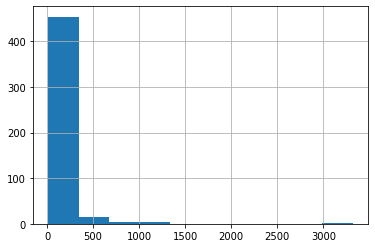

In [50]:
# What is the distribution of playlist's total tracks?
playlist_df['playlist_total_tracks'].hist()

<AxesSubplot:>

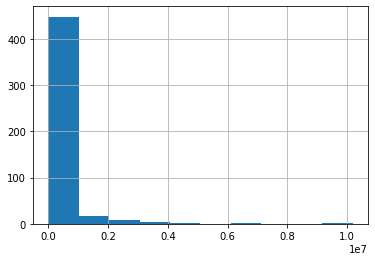

In [51]:
# What is the distribution of playlist's total tracks?
playlist_df['total_followers'].hist()

In [52]:
#tally of tracks
#tracks_df['genre'].value_counts()
tracks_df['genre'].value_counts(normalize=True)

classical    0.272925
jazz         0.199634
pop          0.188772
reggae       0.186028
country      0.152641
Name: genre, dtype: float64

### 2. Refine the training data

In [53]:
#get top 5 playlists per genre
top_playlists_df = playlist_df.groupby('genre').head(5)
top_playlists_df.head()

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DWVqfgj8NZEp1,Coffee Table Jazz,140,spotify,Spotify,2282279,jazz
1,37i9dQZF1DXbITWG1ZJKYt,Jazz Classics,100,spotify,Spotify,1905763,jazz
2,37i9dQZF1DX4wta20PHgwo,Late Night Jazz,80,spotify,Spotify,1852668,jazz
3,37i9dQZF1DX0SM0LYsmbMT,Jazz Vibes,350,spotify,Spotify,1775132,jazz
4,37i9dQZF1DWTbzY5gOVvKd,Jazzy Romance,60,spotify,Spotify,996283,jazz


In [54]:
tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]
tracks_df['genre'].value_counts()

jazz         712
pop          502
classical    473
reggae       466
country      254
Name: genre, dtype: int64

### 3. Feature Engineering

##### Conversions/Normalizations

In [55]:
#convert duration from ms to mins
tracks_df['duration_mins']=tracks_df['duration']/60000

In [56]:
tracks_df['loudness'] = scaler.fit_transform(tracks_df[['loudness']])
tracks_df['loudness'].describe()

count    2407.000000
mean        0.762869
std         0.174076
min         0.000000
25%         0.663653
50%         0.826147
75%         0.894885
max         1.000000
Name: loudness, dtype: float64

In [57]:
#Normalize tempo
tracks_df['tempo'] =  scaler.fit_transform(tracks_df[['tempo']])
#check
tracks_df['tempo'].describe()

count    2407.000000
mean        0.527422
std         0.154373
min         0.000000
25%         0.409178
50%         0.486401
75%         0.623485
max         1.000000
Name: tempo, dtype: float64

###### Categorical Encoding

In [58]:
tracks_df["genre"] = tracks_df["genre"].astype('category')
tracks_df.dtypes

track_id              object
track_name            object
artist_id             object
artist_name           object
album_id              object
duration               int64
release_date          object
popularity             int64
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
playlist_id           object
genre               category
playlist_name         object
duration_mins        float64
dtype: object

In [59]:
tracks_df['genre'].value_counts()

jazz         712
pop          502
classical    473
reggae       466
country      254
Name: genre, dtype: int64

In [60]:
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,genre,playlist_name,duration_mins,genre_id
0,2wOlZrHUpRP9hQbqbV9Ae5,Together,0Cioop2zjxXxtcPUme7R46,Matthew Halsall,1fcREbFQfCqfwxXkxGgvV7,672520,2009-10-26,61,0.401,0.0236,...,0.978,0.57900,0.1020,0.163,0.516468,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,11.208667,2
1,2yiISACbYnL2hApy1ffKKs,Misty - Remastered 2020,6C65D20ASusYqHGSIktfED,Erroll Garner,41sYqKPEygmvQrLXKpzWJU,167121,2020-04-17,62,0.327,0.1450,...,0.945,0.88400,0.0910,0.136,0.836329,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,2.785350,2
2,2R1vQwYTC0sl93C6oyVuHC,Simplicity,0FAC6FNPb4LsY5uyp0xTWF,Edward Simon,4GDYdHheKfIOBMjqOgTK6k,309586,2020-10-09,58,0.493,0.1070,...,0.881,0.90600,0.1220,0.126,0.426777,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,5.159767,2
3,7zzaZggdFuadOs0R7SuJlp,My Ideal,5CSkWcdoRvgBQDwJTZZstJ,Jerry Bergonzi,2T8WUL1jRlaGIqj36oD5O5,219766,2021-01-15,45,0.526,0.0767,...,0.802,0.00195,0.0978,0.247,0.526978,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,3.662767,2
4,7LIFp3v3CaTCvcG6fmceIg,Clouds,7c7414LKkYnuDPlkrwDg9a,Portraits in Jazz,3LEyIlY9P6z9Mvp6dpxk9d,283650,2020-11-27,56,0.338,0.1650,...,0.977,0.31500,0.1220,0.174,0.356400,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,4.727500,2


In [61]:
genre_lookup = dict(tracks_df.groupby('genre_id').head(1)[['genre_id','genre']].values)
genre_lookup

{2: 'jazz', 3: 'pop', 4: 'reggae', 0: 'classical', 1: 'country'}

## 4. Train a KNN model

In [62]:
#test plot for a genre and 2 predictors

# fig = plt.figure()
# ax= fig.add_subplot(111)

# colormaps = ['Reds','Blues']
# genre = 'pop'
# label = ["not "+genre,genre]
# for n,genre_bool in enumerate([0,1]):
#     df=tracks_df[tracks_df['genre_'+genre]==genre_bool]
#     sns.kdeplot(df['energy'],df['tempo'], ax=ax,\
#                 shade=True, shade_lowest=False, alpha=0.5, cmap=colormaps[n],\
#                 label=label[n])
    
# plt.legend(frameon=False)


Tuning the model


Tuning kNN classification model with K-Fold=4...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


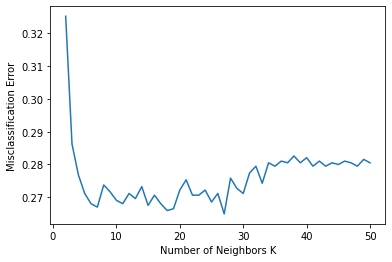

The optimal number of neighbors is 27 with score 73%

Tuning kNN classification model with K-Fold=5...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


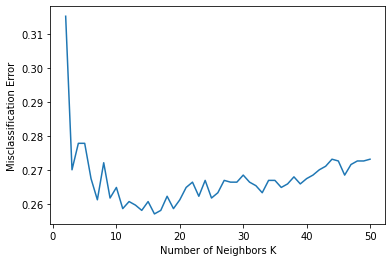

The optimal number of neighbors is 16 with score 74%

Tuning kNN classification model with K-Fold=8...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


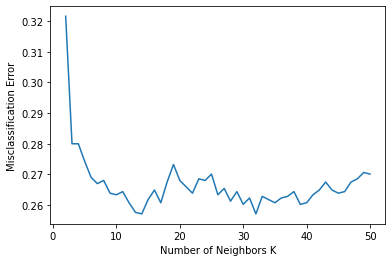

The optimal number of neighbors is 14 with score 74%

Tuning kNN classification model with K-Fold=10...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


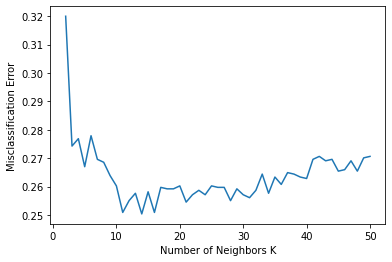

The optimal number of neighbors is 14 with score 74%


In [63]:
#Select audio features to use for the model
feature_cols = ['danceability', 'energy',\
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
       'liveness', 'valence', 'tempo']

results_optimal_k = []  ## Q3

kfolds= [4,5,8,10]

for d in kfolds:
    print('\nTuning kNN classification model with K-Fold=%d...' % d)
    # create feature matrix (X)
    X = tracks_df[feature_cols]
    y = tracks_df['genre_id']

    # creating training set, test set and checking shapes 
    X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
    print("Shape of X_Train:"+str(X_train.shape))
    print("Shape of y_Train:"+str(Y_train.shape))
    print("Shape of X_Test:"+str(X_test.shape))
    print("Shape of y_Test:"+str(Y_test.shape))
    
    #train model
    cv_scores = []
    neighbors=np.arange(2,51)
    print('Finding best k...')
    
    #Perform KNN using K= [1..50] and validate using k-fold k = 5
    for k in neighbors:
        #print('Fitting for k=%d' % k)
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    # changeto misclassification error
    mse = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[mse.index(min(mse))]
    results_optimal_k.append(optimal_k)   ## Q3
    
    knn_optimal = KNeighborsClassifier(n_neighbors=k)
    knn_optimal.fit(X_train, Y_train)
    # plot misclassification error vs k
    plt.plot(neighbors, mse)
    plt.xlabel("Number of Neighbors K")
    plt.ylabel("Misclassification Error")
    plt.show()
    
    print("The optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))


In [64]:
results_optimal_k

[27, 16, 14, 14]

In [66]:
#print(classification_report(y,knn_optimal.predict(X)))
print(classification_report(Y_test, pred))

NameError: name 'pred' is not defined

<ipython-input-39-4585aa7d7007>:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot('1'+str(len(genres))+str(genre_id))
<ipython-input-39-4585aa7d7007>:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot('1'+str(len(genres))+str(genre_id))
<ipython-input-39-4585aa7d7007>:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot('1'+str(len(genres))+str(genre_id))
<ipython-input-39-4585aa7d7007>:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot('1'+str(len(

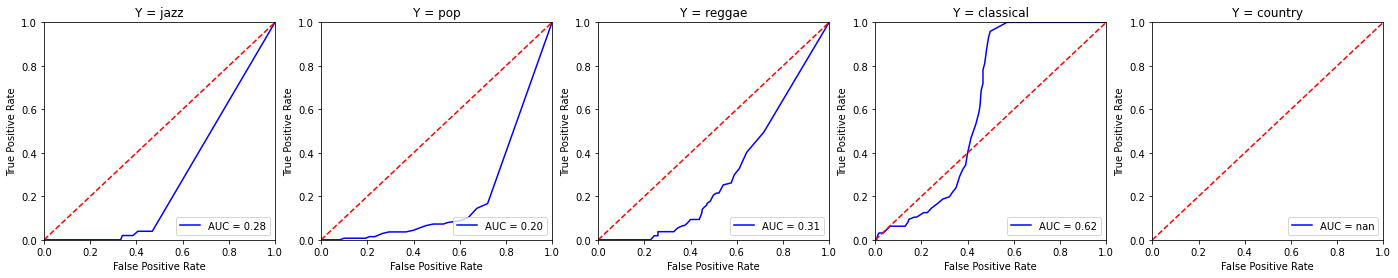

In [39]:
y_scores = knn_optimal.predict_proba(X_test)
genres = tracks_df['genre'].unique()

fig = plt.figure(figsize=[24,4])

for i in np.arange(len(genres)):
    genre_id = i+1
    y_test =[1 if k==genre_id else 0 for k in Y_test]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores[:, i])
    roc_auc = auc(fpr, tpr)

    # ax = fig.add_subplot('1'+str(len(genres))+str(i))
    ax = fig.add_subplot('1'+str(len(genres))+str(genre_id)) 
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('Y = '+str(genres[i]))
    #plt.savefig('AUC.png', dpi=600)


### 5. Model Prediction

In [25]:
#Predict genres of the charting tracks
chart_tracks_df = pd.read_csv("data/spotify_daily_charts_tracks.csv")
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,261240,2016-11-17,76,0.578,0.574,2.0,-6.209,1.0,0.0454,0.196,0.00000,0.0830,0.301,174.152
1,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,4IWBUUAFIplrNtaOHcJPRM,James Arthur,7oiJYvEJHsmYtrgviAVIBD,211466,2016-10-28,85,0.358,0.557,10.0,-7.398,1.0,0.0590,0.695,0.00000,0.0902,0.494,85.043
2,7BKLCZ1jbUBVqRi2FVlTVw,Closer,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0rSLgV8p5FzfnqlEk4GzxE,244960,2016-07-29,85,0.748,0.524,8.0,-5.599,1.0,0.0338,0.414,0.00000,0.1110,0.661,95.010
3,2rizacJSyD9S1IQUxUxnsK,All We Know,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0xmaV6EtJ4M3ebZUPRnhyb,194080,2016-09-29,69,0.662,0.586,0.0,-8.821,1.0,0.0307,0.097,0.00272,0.1150,0.296,90.000
4,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,04gDigrS5kc9YWfZHwBETP,Maroon 5,0fvTn3WXF39kQs9i3bnNpP,214480,2016-10-11,0,0.783,0.623,7.0,-6.126,1.0,0.0800,0.338,0.00000,0.0975,0.447,100.048


In [26]:
#normalize loudness and tempo
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])

Test the model with external data by predicting the genres of the spotify charting tracks!

In [27]:
chart_tracks_df = chart_tracks_df.dropna()
#Predict genres of the spotify charts
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']
genres = [genre_lookup[i] for i in np.arange(len(genre_names))]

n=3 #pick kfold=10
print("Predicting with optimal k: %d" %(results_optimal_k[n]))

knn_optimal = KNeighborsClassifier(n_neighbors=results_optimal_k[n])
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
knn_optimal.fit(X, y)

chart_tracks_df['predicted_genre_id'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0]\
                                               , axis=1)
chart_tracks_df['predicted_genre'] = chart_tracks_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
chart_tracks_df['predicted_genre_prob'] = chart_tracks_df.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1)))\
                                                    , axis=1)
chart_tracks_df['all_genre_prob'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
                                                    , axis=1)


Predicting with optimal k: 16


In [28]:
#explode genre probabilities into separate columns
charts_predicted_genre_prob = pd.DataFrame(chart_tracks_df["all_genre_prob"].to_list(),
                                           columns=['predicted_'+g+'_prob' for g in genres])
charts_predicted_genre_prob['track_id'] = chart_tracks_df['track_id']
chart_tracks_df = pd.merge(chart_tracks_df,charts_predicted_genre_prob, how='left', on='track_id')
chart_tracks_df = chart_tracks_df.drop(columns='all_genre_prob')
chart_tracks_df = chart_tracks_df.sort_values('predicted_genre_prob', ascending=False)
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob
1644,1jo3TwNGCXfNdB5uba3ZVv,Killshot,7dGJo4pcD2V6oG8kP0tJRR,Eminem,0RejlT9bmqcXGrqMaJRos0,253579,2018-09-19,72,0.893,0.651,...,0.6000,0.327736,4,reggae,1.0,0.0,0.4375,0.0000,0.125,0.4375
122,6mICuAdrwEjh6Y6lroV2Kg,Chantaje (feat. Maluma),0EmeFodog0BfCgMzAIvKQp,Shakira,6bUxh58rYTL67FS8dyTKMN,195840,2017-05-26,75,0.852,0.773,...,0.9070,0.304348,4,reggae,1.0,0.0,0.0000,0.0000,0.000,1.0000
1789,0AG2l0IboWNSwjUkMr2Aq7,Be My Mistake,3mIj9lX2MWuHmhNCA7LSCW,The 1975,7zuAt0boSPInT1b0sKyQMk,256688,2018-11-30,0,0.572,0.155,...,0.0949,0.352890,2,jazz,1.0,0.0,0.4375,0.1250,0.125,0.3125
1266,5B03nSG8pLE48jh7kmasuL,Levels - Radio Edit,1vCWHaC5f2uS3yhpwWbIA6,Avicii,16WbLPydnmtI3gQJ4MHZ9J,201920,2013-01-01,42,0.579,0.887,...,0.4720,0.452067,2,jazz,1.0,0.0,0.3750,0.0625,0.375,0.1875
2953,6QBZlIxCB2lAPU2bM1ut1p,Dynamite - Instrumental,3Nrfpe0tUJi4K4DXYWgMUX,BTS,3zWmE5c3alhuoPLphxjMVd,198770,2020-08-21,1,0.861,0.658,...,0.6250,0.377977,2,jazz,1.0,0.0,0.0000,0.5000,0.500,0.0000


Check out tracks with highest assigned probability

In [29]:
chart_tracks_df.groupby('predicted_genre_id').head()[['artist_name','track_name','predicted_genre_id', 'predicted_genre','predicted_genre_prob']]  ## QUESTION 2

chart_tracks_df[['artist_name','track_name','predicted_genre_id', 'predicted_genre','predicted_genre_prob']].sort_values(['predicted_genre_id', 'predicted_genre_prob'], ascending=[True, False])

,artist_name,track_name,predicted_genre_id,predicted_genre,predicted_genre_prob
2834,HONNE,dear P,0,classical,1.0000
2770,Lady Gaga,Chromatica II,0,classical,0.8125
1000,Gary Valenciano,Pasko Na Sinta Ko,0,classical,0.8125
1115,Austyn Johnson,A Million Dreams (Reprise),0,classical,0.7500
1834,Bing Crosby,White Christmas,0,classical,0.7500
...,...,...,...,...,...
1722,ZAYN,Fingers,4,reggae,0.3125
3265,"Grover Washington, Jr.",Just the Two of Us (feat. Bill Withers),4,reggae,0.3125
3049,LANY,cowboy in LA,4,reggae,0.3125
888,Eminem,Walk On Water (feat. Beyoncé),4,reggae,0.3125


View histogram of predicted genre probabilities

<AxesSubplot:>

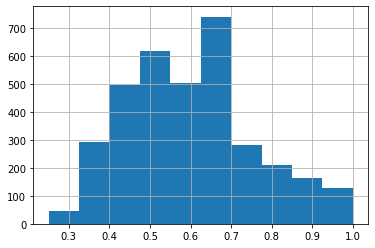

In [30]:
chart_tracks_df['predicted_genre_prob'].hist()

Check out tally of predicted genres

In [31]:
chart_tracks_df['predicted_genre'].value_counts()

pop          1398
reggae        988
country       591
jazz          496
classical      16
Name: predicted_genre, dtype: int64

>Q **Spot Check**: Check out a song you're familiar with and see if the predicted genres and probabilities makes sense

In [32]:
this_song = 'Lay Me Down'
chart_tracks_df[chart_tracks_df['track_name'].str.contains('Lay Me Down')]

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob
762,64GRDrL1efgXclrhVCeuA0,Lay Me Down,2wY79sveU1sp5g7SokKOiI,Sam Smith,0vrWqbRQEMKqhTGcDLQK7x,219535,2015-11-06,75,0.468,0.19,...,0.326,0.447624,2,jazz,0.8125,0.0,0.0625,0.0,0.5,0.4375


In [33]:
#save data
chart_tracks_df.to_csv("data/spotify_daily_charts_tracks_predicted_genres.csv", index=False, encoding='utf-8')

## Part 2. Recommender Engine

In [34]:
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob
1644,1jo3TwNGCXfNdB5uba3ZVv,Killshot,7dGJo4pcD2V6oG8kP0tJRR,Eminem,0RejlT9bmqcXGrqMaJRos0,253579,2018-09-19,72,0.893,0.651,...,0.6000,0.327736,4,reggae,1.0,0.0,0.4375,0.0000,0.125,0.4375
122,6mICuAdrwEjh6Y6lroV2Kg,Chantaje (feat. Maluma),0EmeFodog0BfCgMzAIvKQp,Shakira,6bUxh58rYTL67FS8dyTKMN,195840,2017-05-26,75,0.852,0.773,...,0.9070,0.304348,4,reggae,1.0,0.0,0.0000,0.0000,0.000,1.0000
1789,0AG2l0IboWNSwjUkMr2Aq7,Be My Mistake,3mIj9lX2MWuHmhNCA7LSCW,The 1975,7zuAt0boSPInT1b0sKyQMk,256688,2018-11-30,0,0.572,0.155,...,0.0949,0.352890,2,jazz,1.0,0.0,0.4375,0.1250,0.125,0.3125
1266,5B03nSG8pLE48jh7kmasuL,Levels - Radio Edit,1vCWHaC5f2uS3yhpwWbIA6,Avicii,16WbLPydnmtI3gQJ4MHZ9J,201920,2013-01-01,42,0.579,0.887,...,0.4720,0.452067,2,jazz,1.0,0.0,0.3750,0.0625,0.375,0.1875
2953,6QBZlIxCB2lAPU2bM1ut1p,Dynamite - Instrumental,3Nrfpe0tUJi4K4DXYWgMUX,BTS,3zWmE5c3alhuoPLphxjMVd,198770,2020-08-21,1,0.861,0.658,...,0.6250,0.377977,2,jazz,1.0,0.0,0.0000,0.5000,0.500,0.0000


In [35]:
chart_tracks_df.columns

Index(['track_id', 'track_name', 'artist_id', 'artist_name', 'album_id',
       'duration', 'release_date', 'popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'predicted_genre_id', 'predicted_genre', 'predicted_genre_prob',
       'predicted_classical_prob', 'predicted_country_prob',
       'predicted_jazz_prob', 'predicted_pop_prob', 'predicted_reggae_prob'],
      dtype='object')

In [36]:
#read data
britney_df=pd.read_csv("data/Britney Spears_playlist_tracks_data.csv")
#normalize loudness and tempo
scaler = MinMaxScaler()
britney_df['loudness'] = scaler.fit_transform(britney_df[['loudness']])
britney_df['tempo'] =  scaler.fit_transform(britney_df[['tempo']])
britney_df  ## QUESTION 1


,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,0.713767,0,0.0307,0.2020,0.000131,0.4430,0.907,0.218504,3MjUtNVVq3C8Fn0MP3zhXa,3MjUtNVVq3C8Fn0MP3zhXa
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,0.807438,0,0.1140,0.0249,0.025000,0.2420,0.924,0.550393,6I9VzXrHxO9rA9A5euc8Ak,6I9VzXrHxO9rA9A5euc8Ak
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,0.729166,0,0.0437,0.3000,0.000018,0.3550,0.894,0.232375,6naxalmIoLFWR0siv8dnQQ,6naxalmIoLFWR0siv8dnQQ
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,0.740318,1,0.0622,0.0730,0.000000,0.0889,0.235,0.523619,4fixebDZAVToLbUCuEloa2,4fixebDZAVToLbUCuEloa2
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,0.847496,1,0.0334,0.2500,0.000678,0.0723,0.382,0.353460,6ic8OlLUNEATToEFU3xmaH,6ic8OlLUNEATToEFU3xmaH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,3K2lg4fY3CunPMeNlMnR32,Are You Gonna Be There,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,246586,2014-07-29,34,0.472,0.725,...,0.729268,1,0.0314,0.1980,0.000000,0.1390,0.409,0.172578,3K2lg4fY3CunPMeNlMnR32,3K2lg4fY3CunPMeNlMnR32
1188,50haJiO2RhVsnTQ0Iu7lYS,For the Girl Who Has Everything - Radio Mix,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,236746,2014-07-29,28,0.579,0.617,...,0.666598,0,0.0291,0.1700,0.000000,0.0805,0.596,0.730261,50haJiO2RhVsnTQ0Iu7lYS,50haJiO2RhVsnTQ0Iu7lYS
1189,0T9Aq8S8WKdXXh6EXM8cB8,If I'm Not the One,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,201413,2014-07-29,30,0.779,0.835,...,0.737044,0,0.0378,0.1620,0.000000,0.2550,0.936,0.291774,0T9Aq8S8WKdXXh6EXM8cB8,0T9Aq8S8WKdXXh6EXM8cB8
1190,0S2AEPvmKGcdRYgqQP7MXq,Music of My Heart,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,270893,2014-07-29,30,0.537,0.606,...,0.648079,1,0.0382,0.3920,0.000000,0.0903,0.411,0.345216,0S2AEPvmKGcdRYgqQP7MXq,0S2AEPvmKGcdRYgqQP7MXq


In [37]:
# Input seed track here
seed_track_name = 'Oops!...I Did It Again'

In [38]:
feature_cols = ['danceability', 'energy',\
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
       'liveness', 'valence', 'tempo']

In [39]:
# seed_track_data = chart_tracks_df[chart_tracks_df['track_name']==seed_track_name].iloc[0]
# seed_track_data[feature_cols]

In [40]:
seed_track_data = pd.read_csv('data/Britney Spears_playlist_tracks_data.csv')
seed_track_data = seed_track_data[feature_cols].iloc[1]
seed_track_data

danceability          0.7740
energy                0.8380
loudness             -3.9140
speechiness           0.1140
acousticness          0.0249
instrumentalness      0.0250
liveness              0.2420
valence               0.9240
tempo               143.0400
Name: 1, dtype: float64

In [41]:
seed_track_data['track_id'] = '6naxalmIoLFWR0siv8dnQQ'
seed_track_data

danceability                         0.774
energy                               0.838
loudness                            -3.914
speechiness                          0.114
acousticness                        0.0249
instrumentalness                     0.025
liveness                             0.242
valence                              0.924
tempo                               143.04
track_id            6naxalmIoLFWR0siv8dnQQ
Name: 1, dtype: object

In [42]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

In [43]:
chart_tracks_df['euclidean_dist'] = chart_tracks_df.apply(lambda x: euclidean_distances(x[feature_cols].values.reshape(-1, 1),\
                                                                  seed_track_data[feature_cols].values.reshape(-1, 1))\
                                                                  .flatten()[0], axis=1)
#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']].sort_values('euclidean_dist')[:10]
recommendation_df[['track_name','artist_name','euclidean_dist','predicted_genre']+feature_cols]

,track_name,artist_name,euclidean_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
3222,Wonderful Christmastime - Edited Version / Rem...,Paul McCartney,0.000,reggae,0.774,0.511,0.627881,0.0319,0.3220,0.000000,0.0672,0.771,0.259442
450,Attention,Charlie Puth,0.000,reggae,0.774,0.626,0.811382,0.0432,0.0969,0.000031,0.0848,0.777,0.292085
2571,Blueberry Faygo,Lil Mosey,0.000,pop,0.774,0.554,0.669028,0.0383,0.2070,0.000000,0.1320,0.349,0.285888
29,Shout Out to My Ex,Little Mix,0.000,pop,0.774,0.739,0.828168,0.0952,0.0316,0.000006,0.1190,0.823,0.451827
94,Cake By The Ocean,DNCE,0.000,reggae,0.774,0.764,0.769908,0.0518,0.1560,0.000000,0.0383,0.912,0.408724
1299,Shout Out to My Ex,Little Mix,0.000,pop,0.774,0.739,0.828168,0.0952,0.0316,0.000006,0.1190,0.823,0.451827
1823,Wonderful Christmastime [Edited Version] - Rem...,Paul McCartney,0.000,reggae,0.774,0.511,0.627881,0.0319,0.3220,0.000000,0.0672,0.771,0.259442
3239,Cozy Little Christmas,Katy Perry,0.000,pop,0.774,0.608,0.736377,0.1280,0.1280,0.000000,0.0895,0.560,0.522539
1467,all the kids are depressed,Jeremy Zucker,0.001,jazz,0.773,0.437,0.653797,0.0963,0.8360,0.000024,0.5440,0.707,0.315590
1820,Hope,The Chainsmokers,0.001,reggae,0.773,0.699,0.747922,0.0958,0.4880,0.000004,0.0814,0.513,0.322235


In [44]:
chart_tracks_df['manhattan_dist'] = chart_tracks_df.apply(lambda x: manhattan_distances(x[feature_cols].values.reshape(-1, 1),\
                                                                  seed_track_data[feature_cols].values.reshape(-1, 1))\
                                                                  .flatten()[0], axis=1)
#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']].sort_values('manhattan_dist')[:10]
recommendation_df[['track_name','artist_name','manhattan_dist','predicted_genre']+feature_cols]

,track_name,artist_name,manhattan_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
2571,Blueberry Faygo,Lil Mosey,0.000,pop,0.774,0.554,0.669028,0.0383,0.2070,0.000000,0.1320,0.349,0.285888
450,Attention,Charlie Puth,0.000,reggae,0.774,0.626,0.811382,0.0432,0.0969,0.000031,0.0848,0.777,0.292085
3239,Cozy Little Christmas,Katy Perry,0.000,pop,0.774,0.608,0.736377,0.1280,0.1280,0.000000,0.0895,0.560,0.522539
3222,Wonderful Christmastime - Edited Version / Rem...,Paul McCartney,0.000,reggae,0.774,0.511,0.627881,0.0319,0.3220,0.000000,0.0672,0.771,0.259442
29,Shout Out to My Ex,Little Mix,0.000,pop,0.774,0.739,0.828168,0.0952,0.0316,0.000006,0.1190,0.823,0.451827
1823,Wonderful Christmastime [Edited Version] - Rem...,Paul McCartney,0.000,reggae,0.774,0.511,0.627881,0.0319,0.3220,0.000000,0.0672,0.771,0.259442
94,Cake By The Ocean,DNCE,0.000,reggae,0.774,0.764,0.769908,0.0518,0.1560,0.000000,0.0383,0.912,0.408724
1299,Shout Out to My Ex,Little Mix,0.000,pop,0.774,0.739,0.828168,0.0952,0.0316,0.000006,0.1190,0.823,0.451827
299,As Long as You Love Me,Backstreet Boys,0.001,reggae,0.775,0.816,0.766264,0.0281,0.1640,0.000000,0.1260,0.753,0.280874
2525,The Weekend - Funk Wav Remix,SZA,0.001,reggae,0.775,0.573,0.790870,0.0585,0.4950,0.000000,0.1260,0.667,0.303677


In [45]:
#compute cosine distances, audio features only
chart_tracks_df['cosine_dist'] = chart_tracks_df.apply(lambda x: 1-cosine_similarity(x[feature_cols].values.reshape(1, -1),\
                                                                  seed_track_data[feature_cols].values.reshape(1, -1))\
                                                                  .flatten()[0], axis=1)

chart_tracks_df.sort_values(by='cosine_dist',ascending=False).head()

#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']].sort_values('cosine_dist')[:10]
recommendation_df[['track_name','artist_name','cosine_dist','predicted_genre']+feature_cols]

,track_name,artist_name,cosine_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
3244,Snowfall on Christmas Eve,The Rossman Ensemble,0.300439,reggae,0.575,0.411,0.536663,0.0722,0.0251,0.069300,0.0751,0.4620,1.000000
1600,"Kahit Maputi Na Ang Buhok ko - From ""The Hows ...",Moira Dela Torre,0.331884,country,0.264,0.273,0.638649,0.0312,0.5350,0.000000,0.2070,0.3150,0.911930
1781,Demonyo,juan karlos,0.334029,pop,0.415,0.508,0.617441,0.0363,0.0509,0.016200,0.1030,0.1140,0.837889
3412,Untouchable (Taylor’s Version),Taylor Swift,0.349277,pop,0.393,0.531,0.742600,0.0329,0.0181,0.000000,0.1690,0.2240,0.909555
1529,"Closer You and I - From ""Loving in Tandem""",Michael Pangilinan,0.349364,pop,0.207,0.535,0.713613,0.0414,0.2010,0.000000,0.3360,0.2640,0.906589
755,Dusk Till Dawn - Radio Edit,ZAYN,0.356358,pop,0.258,0.437,0.722907,0.0390,0.1010,0.000001,0.1060,0.0967,0.784350
808,Pray,Sam Smith,0.360518,pop,0.381,0.379,0.609621,0.0501,0.2920,0.000003,0.0864,0.1530,0.753732
1011,Bibingka,Ben&Ben,0.367287,jazz,0.356,0.229,0.502149,0.0328,0.7970,0.000000,0.1120,0.4310,0.932217
2977,The Bells At Christmas,Jose Mari Chan,0.369371,country,0.227,0.352,0.572242,0.0321,0.3160,0.000001,0.1290,0.6760,0.856871
1085,The Good Side,Troye Sivan,0.375492,jazz,0.424,0.259,0.316929,0.0531,0.4180,0.002470,0.3540,0.3160,0.696434


array([[<AxesSubplot:title={'center':'euclidean_dist'}>,
        <AxesSubplot:title={'center':'manhattan_dist'}>],
       [<AxesSubplot:title={'center':'cosine_dist'}>, <AxesSubplot:>]],
      dtype=object)

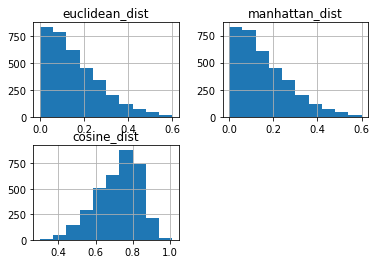

In [46]:
chart_tracks_df[['euclidean_dist','manhattan_dist','cosine_dist']].hist()

Modify similarity criteria

In [47]:
bs_df = pd.read_csv('data/Britney Spears_playlist_tracks_data.csv')
bs_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,-5.745,0,0.0307,0.2020,0.000131,0.4430,0.907,92.960,3MjUtNVVq3C8Fn0MP3zhXa,3MjUtNVVq3C8Fn0MP3zhXa
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,-3.914,0,0.1140,0.0249,0.025000,0.2420,0.924,143.040,6I9VzXrHxO9rA9A5euc8Ak,6I9VzXrHxO9rA9A5euc8Ak
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,6naxalmIoLFWR0siv8dnQQ,6naxalmIoLFWR0siv8dnQQ
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,-5.226,1,0.0622,0.0730,0.000000,0.0889,0.235,139.000,4fixebDZAVToLbUCuEloa2,4fixebDZAVToLbUCuEloa2
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,-3.131,1,0.0334,0.2500,0.000678,0.0723,0.382,113.324,6ic8OlLUNEATToEFU3xmaH,6ic8OlLUNEATToEFU3xmaH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,3K2lg4fY3CunPMeNlMnR32,Are You Gonna Be There,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,246586,2014-07-29,34,0.472,0.725,...,-5.442,1,0.0314,0.1980,0.000000,0.1390,0.409,86.030,3K2lg4fY3CunPMeNlMnR32,3K2lg4fY3CunPMeNlMnR32
1188,50haJiO2RhVsnTQ0Iu7lYS,For the Girl Who Has Everything - Radio Mix,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,236746,2014-07-29,28,0.579,0.617,...,-6.667,0,0.0291,0.1700,0.000000,0.0805,0.596,170.181,50haJiO2RhVsnTQ0Iu7lYS,50haJiO2RhVsnTQ0Iu7lYS
1189,0T9Aq8S8WKdXXh6EXM8cB8,If I'm Not the One,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,201413,2014-07-29,30,0.779,0.835,...,-5.290,0,0.0378,0.1620,0.000000,0.2550,0.936,104.016,0T9Aq8S8WKdXXh6EXM8cB8,0T9Aq8S8WKdXXh6EXM8cB8
1190,0S2AEPvmKGcdRYgqQP7MXq,Music of My Heart,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,270893,2014-07-29,30,0.537,0.606,...,-7.029,1,0.0382,0.3920,0.000000,0.0903,0.411,112.080,0S2AEPvmKGcdRYgqQP7MXq,0S2AEPvmKGcdRYgqQP7MXq


In [48]:
bs_df = bs_df[bs_df.artist_name == 'Britney Spears'].drop_duplicates()[bs_df.columns[:-2]]
bs_df = bs_df.drop_duplicates(subset='track_name')
bs_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,0,-5.745,0,0.0307,0.202000,0.000131,0.4430,0.907,92.960
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,5,-3.914,0,0.1140,0.024900,0.025000,0.2420,0.924,143.040
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,1,-5.444,0,0.0437,0.300000,0.000018,0.3550,0.894,95.053
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,11,-5.226,1,0.0622,0.073000,0.000000,0.0889,0.235,139.000
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,2,-3.131,1,0.0334,0.250000,0.000678,0.0723,0.382,113.324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,5GP8vMD6WaOffDeJfbit0m,"Gimme More (""Kimme More"" Remix) (feat. Lil' Kim)",26dSoYclwsYLMAKD3tpOr4,Britney Spears,5OKcpFYgWvyiYhEG6Bdoyc,252720,2008-01-08,43,0.782,0.887,2,-2.356,1,0.0743,0.265000,0.000013,0.1860,0.490,113.303
538,0cG2rnJV6G9GqYHOesbM4U,Radar - Tonal Club Remix,26dSoYclwsYLMAKD3tpOr4,Britney Spears,6KyOIN8ljZIuggUSvcCnuI,295413,2011-10-07,21,0.661,0.834,1,-5.451,0,0.0490,0.000112,0.662000,0.1360,0.110,127.997
539,6H01lZiYF1zWlPqpJlu9as,Gimme More - Remastered,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2ti2e8J05nwg9ikcMjW8aS,251840,2014-07-29,55,0.793,0.849,2,-3.429,1,0.0330,0.293000,0.004170,0.0630,0.405,113.298
851,0FzZkbdKATBMU4fKHXah3R,From the Bottom of My Broken Heart - Radio Edi...,26dSoYclwsYLMAKD3tpOr4,Britney Spears,325wcm5wMnlfjmKZ8PXIIn,274133,2009-11-09,27,0.667,0.602,7,-6.707,1,0.0299,0.335000,0.000000,0.3700,0.635,74.970


In [49]:
chart_df = pd.read_csv("data/spotify_daily_charts_tracks.csv").drop_duplicates()
chart_df = chart_df[chart_df.artist_name != 'Britney Spears']
chart_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,261240,2016-11-17,76,0.578,0.574,2.0,-6.209,1.0,0.0454,0.19600,0.000000,0.0830,0.301,174.152
1,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,4IWBUUAFIplrNtaOHcJPRM,James Arthur,7oiJYvEJHsmYtrgviAVIBD,211466,2016-10-28,85,0.358,0.557,10.0,-7.398,1.0,0.0590,0.69500,0.000000,0.0902,0.494,85.043
2,7BKLCZ1jbUBVqRi2FVlTVw,Closer,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0rSLgV8p5FzfnqlEk4GzxE,244960,2016-07-29,85,0.748,0.524,8.0,-5.599,1.0,0.0338,0.41400,0.000000,0.1110,0.661,95.010
3,2rizacJSyD9S1IQUxUxnsK,All We Know,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0xmaV6EtJ4M3ebZUPRnhyb,194080,2016-09-29,69,0.662,0.586,0.0,-8.821,1.0,0.0307,0.09700,0.002720,0.1150,0.296,90.000
4,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,04gDigrS5kc9YWfZHwBETP,Maroon 5,0fvTn3WXF39kQs9i3bnNpP,214480,2016-10-11,0,0.783,0.623,7.0,-6.126,1.0,0.0800,0.33800,0.000000,0.0975,0.447,100.048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3490,2zrhoHlFKxFTRF5aMyxMoQ,Next Level,6YVMFz59CuY7ngCxTxjpxE,aespa,2CzbrboOLzeRoaaH1N5K0N,221573,2021-05-17,74,0.820,0.852,11.0,-2.567,0.0,0.1660,0.48800,0.000006,0.0907,0.820,109.036
3491,2UbVnbE5FH6008mAm6Mmgw,Run,5Pwc4xIPtQLFEnJriah9YJ,OneRepublic,4d0a5uamW9NWRc1KXFeErI,169010,2021-05-05,82,0.682,0.720,11.0,-8.173,0.0,0.0381,0.32600,0.000000,0.1480,0.673,117.003
3492,7I9RoRcJ0N9rvN4p4KWPsH,Paraluman,3Dr5ezvDdYsycy1gfaZWSL,raven,2eKPpTGmSRX3bfBZm9QxiN,224578,2021-02-18,58,0.745,0.497,2.0,-5.767,1.0,0.1360,0.00611,0.033000,0.1830,0.438,75.019
3493,2RFzaIg3tJhvJdNIUqvr9R,Got It Like That,0UntV1Bw2hk3fbRrm9eMP6,B.I,4LIOJLYeTXrz6rvfk0O6xK,178775,2021-05-14,64,0.803,0.519,5.0,-8.210,1.0,0.0359,0.08500,0.000078,0.3060,0.644,97.966


In [50]:
combined_df = pd.concat([bs_df, chart_df]).dropna()
combined_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,0.0,-5.745,0.0,0.0307,0.20200,0.000131,0.4430,0.907,92.960
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,5.0,-3.914,0.0,0.1140,0.02490,0.025000,0.2420,0.924,143.040
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,1.0,-5.444,0.0,0.0437,0.30000,0.000018,0.3550,0.894,95.053
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,11.0,-5.226,1.0,0.0622,0.07300,0.000000,0.0889,0.235,139.000
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,2.0,-3.131,1.0,0.0334,0.25000,0.000678,0.0723,0.382,113.324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3489,6Fz2TpxUD0YvAPsuG8nDMJ,MAPA,3g7vYcdDXnqnDKYFwqXBJP,SB19,4Qhx57hNp0CUmUbO2igtAq,275420,2021-05-16,58,0.561,0.651,9.0,-4.862,1.0,0.0689,0.30900,0.000000,0.3780,0.355,129.957
3490,2zrhoHlFKxFTRF5aMyxMoQ,Next Level,6YVMFz59CuY7ngCxTxjpxE,aespa,2CzbrboOLzeRoaaH1N5K0N,221573,2021-05-17,74,0.820,0.852,11.0,-2.567,0.0,0.1660,0.48800,0.000006,0.0907,0.820,109.036
3491,2UbVnbE5FH6008mAm6Mmgw,Run,5Pwc4xIPtQLFEnJriah9YJ,OneRepublic,4d0a5uamW9NWRc1KXFeErI,169010,2021-05-05,82,0.682,0.720,11.0,-8.173,0.0,0.0381,0.32600,0.000000,0.1480,0.673,117.003
3492,7I9RoRcJ0N9rvN4p4KWPsH,Paraluman,3Dr5ezvDdYsycy1gfaZWSL,raven,2eKPpTGmSRX3bfBZm9QxiN,224578,2021-02-18,58,0.745,0.497,2.0,-5.767,1.0,0.1360,0.00611,0.033000,0.1830,0.438,75.019


In [51]:
# feature scaling
combined_df[['loudness', 'tempo']] = scaler.fit_transform(combined_df[['loudness', 'tempo']])
combined_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,0.0,0.757625,0.0,0.0307,0.20200,0.000131,0.4430,0.907,0.248514
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,5.0,0.832590,0.0,0.1140,0.02490,0.025000,0.2420,0.924,0.556664
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,1.0,0.769949,0.0,0.0437,0.30000,0.000018,0.3550,0.894,0.261393
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,11.0,0.778874,1.0,0.0622,0.07300,0.000000,0.0889,0.235,0.531806
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,2.0,0.864647,1.0,0.0334,0.25000,0.000678,0.0723,0.382,0.373817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3489,6Fz2TpxUD0YvAPsuG8nDMJ,MAPA,3g7vYcdDXnqnDKYFwqXBJP,SB19,4Qhx57hNp0CUmUbO2igtAq,275420,2021-05-16,58,0.561,0.651,9.0,0.793777,1.0,0.0689,0.30900,0.000000,0.3780,0.355,0.476163
3490,2zrhoHlFKxFTRF5aMyxMoQ,Next Level,6YVMFz59CuY7ngCxTxjpxE,aespa,2CzbrboOLzeRoaaH1N5K0N,221573,2021-05-17,74,0.820,0.852,11.0,0.887738,0.0,0.1660,0.48800,0.000006,0.0907,0.820,0.347432
3491,2UbVnbE5FH6008mAm6Mmgw,Run,5Pwc4xIPtQLFEnJriah9YJ,OneRepublic,4d0a5uamW9NWRc1KXFeErI,169010,2021-05-05,82,0.682,0.720,11.0,0.658219,0.0,0.0381,0.32600,0.000000,0.1480,0.673,0.396455
3492,7I9RoRcJ0N9rvN4p4KWPsH,Paraluman,3Dr5ezvDdYsycy1gfaZWSL,raven,2eKPpTGmSRX3bfBZm9QxiN,224578,2021-02-18,58,0.745,0.497,2.0,0.756725,1.0,0.1360,0.00611,0.033000,0.1830,0.438,0.138120


In [52]:
# genre clasification to combined df using knn_optimal classifcation model
genres = [genre_lookup[i] for i in np.arange(len(genre_names))]

combined_df['predicted_genre_id'] = combined_df.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0], axis=1)
combined_df['predicted_genre'] = combined_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
combined_df['predicted_genre_prob'] = combined_df.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))), axis=1)
# combined_df['all_genre_prob'] = combined_df.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0], axis=1)   ## Q4

predictions_df = combined_df.reset_index(drop=True)
predictions_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,0.0,0.0307,0.20200,0.000131,0.4430,0.907,0.248514,4,reggae,0.7500
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,0.0,0.1140,0.02490,0.025000,0.2420,0.924,0.556664,3,pop,0.4375
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,0.0,0.0437,0.30000,0.000018,0.3550,0.894,0.261393,4,reggae,0.9375
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,1.0,0.0622,0.07300,0.000000,0.0889,0.235,0.531806,3,pop,0.6250
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,1.0,0.0334,0.25000,0.000678,0.0723,0.382,0.373817,4,reggae,0.9375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3671,6Fz2TpxUD0YvAPsuG8nDMJ,MAPA,3g7vYcdDXnqnDKYFwqXBJP,SB19,4Qhx57hNp0CUmUbO2igtAq,275420,2021-05-16,58,0.561,0.651,...,1.0,0.0689,0.30900,0.000000,0.3780,0.355,0.476163,3,pop,0.4375
3672,2zrhoHlFKxFTRF5aMyxMoQ,Next Level,6YVMFz59CuY7ngCxTxjpxE,aespa,2CzbrboOLzeRoaaH1N5K0N,221573,2021-05-17,74,0.820,0.852,...,0.0,0.1660,0.48800,0.000006,0.0907,0.820,0.347432,4,reggae,0.8750
3673,2UbVnbE5FH6008mAm6Mmgw,Run,5Pwc4xIPtQLFEnJriah9YJ,OneRepublic,4d0a5uamW9NWRc1KXFeErI,169010,2021-05-05,82,0.682,0.720,...,0.0,0.0381,0.32600,0.000000,0.1480,0.673,0.396455,4,reggae,0.4375
3674,7I9RoRcJ0N9rvN4p4KWPsH,Paraluman,3Dr5ezvDdYsycy1gfaZWSL,raven,2eKPpTGmSRX3bfBZm9QxiN,224578,2021-02-18,58,0.745,0.497,...,1.0,0.1360,0.00611,0.033000,0.1830,0.438,0.138120,4,reggae,0.8125


In [53]:
# save dataset
predictions_df.to_csv('data/genre_predictions.csv', index=False)

In [54]:
predictions_df = pd.read_csv('data/genre_predictions.csv')
predictions_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,0.0,0.0307,0.20200,0.000131,0.4430,0.907,0.248514,4,reggae,0.7500
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,0.0,0.1140,0.02490,0.025000,0.2420,0.924,0.556664,3,pop,0.4375
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,0.0,0.0437,0.30000,0.000018,0.3550,0.894,0.261393,4,reggae,0.9375
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,1.0,0.0622,0.07300,0.000000,0.0889,0.235,0.531806,3,pop,0.6250
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,1.0,0.0334,0.25000,0.000678,0.0723,0.382,0.373817,4,reggae,0.9375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3671,6Fz2TpxUD0YvAPsuG8nDMJ,MAPA,3g7vYcdDXnqnDKYFwqXBJP,SB19,4Qhx57hNp0CUmUbO2igtAq,275420,2021-05-16,58,0.561,0.651,...,1.0,0.0689,0.30900,0.000000,0.3780,0.355,0.476163,3,pop,0.4375
3672,2zrhoHlFKxFTRF5aMyxMoQ,Next Level,6YVMFz59CuY7ngCxTxjpxE,aespa,2CzbrboOLzeRoaaH1N5K0N,221573,2021-05-17,74,0.820,0.852,...,0.0,0.1660,0.48800,0.000006,0.0907,0.820,0.347432,4,reggae,0.8750
3673,2UbVnbE5FH6008mAm6Mmgw,Run,5Pwc4xIPtQLFEnJriah9YJ,OneRepublic,4d0a5uamW9NWRc1KXFeErI,169010,2021-05-05,82,0.682,0.720,...,0.0,0.0381,0.32600,0.000000,0.1480,0.673,0.396455,4,reggae,0.4375
3674,7I9RoRcJ0N9rvN4p4KWPsH,Paraluman,3Dr5ezvDdYsycy1gfaZWSL,raven,2eKPpTGmSRX3bfBZm9QxiN,224578,2021-02-18,58,0.745,0.497,...,1.0,0.1360,0.00611,0.033000,0.1830,0.438,0.138120,4,reggae,0.8125


In [55]:
britney_df = predictions_df[predictions_df.artist_name == 'Britney Spears']
britney_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,0.0,0.0307,0.202000,0.000131,0.4430,0.907,0.248514,4,reggae,0.7500
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,0.0,0.1140,0.024900,0.025000,0.2420,0.924,0.556664,3,pop,0.4375
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,0.0,0.0437,0.300000,0.000018,0.3550,0.894,0.261393,4,reggae,0.9375
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,1.0,0.0622,0.073000,0.000000,0.0889,0.235,0.531806,3,pop,0.6250
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,1.0,0.0334,0.250000,0.000678,0.0723,0.382,0.373817,4,reggae,0.9375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,5GP8vMD6WaOffDeJfbit0m,"Gimme More (""Kimme More"" Remix) (feat. Lil' Kim)",26dSoYclwsYLMAKD3tpOr4,Britney Spears,5OKcpFYgWvyiYhEG6Bdoyc,252720,2008-01-08,43,0.782,0.887,...,1.0,0.0743,0.265000,0.000013,0.1860,0.490,0.373688,4,reggae,0.9375
187,0cG2rnJV6G9GqYHOesbM4U,Radar - Tonal Club Remix,26dSoYclwsYLMAKD3tpOr4,Britney Spears,6KyOIN8ljZIuggUSvcCnuI,295413,2011-10-07,21,0.661,0.834,...,0.0,0.0490,0.000112,0.662000,0.1360,0.110,0.464102,2,jazz,0.8750
188,6H01lZiYF1zWlPqpJlu9as,Gimme More - Remastered,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2ti2e8J05nwg9ikcMjW8aS,251840,2014-07-29,55,0.793,0.849,...,1.0,0.0330,0.293000,0.004170,0.0630,0.405,0.373657,4,reggae,0.9375
189,0FzZkbdKATBMU4fKHXah3R,From the Bottom of My Broken Heart - Radio Edi...,26dSoYclwsYLMAKD3tpOr4,Britney Spears,325wcm5wMnlfjmKZ8PXIIn,274133,2009-11-09,27,0.667,0.602,...,1.0,0.0299,0.335000,0.000000,0.3700,0.635,0.137819,4,reggae,0.3750


In [56]:
others_df = predictions_df[predictions_df.artist_name != 'Britney Spears']
others_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob
191,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,261240,2016-11-17,76,0.578,0.574,...,1.0,0.0454,0.19600,0.000000,0.0830,0.301,0.748102,3,pop,0.6250
192,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,4IWBUUAFIplrNtaOHcJPRM,James Arthur,7oiJYvEJHsmYtrgviAVIBD,211466,2016-10-28,85,0.358,0.557,...,1.0,0.0590,0.69500,0.000000,0.0902,0.494,0.199799,3,pop,0.5000
193,7BKLCZ1jbUBVqRi2FVlTVw,Closer,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0rSLgV8p5FzfnqlEk4GzxE,244960,2016-07-29,85,0.748,0.524,...,1.0,0.0338,0.41400,0.000000,0.1110,0.661,0.261128,3,pop,0.3125
194,2rizacJSyD9S1IQUxUxnsK,All We Know,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0xmaV6EtJ4M3ebZUPRnhyb,194080,2016-09-29,69,0.662,0.586,...,1.0,0.0307,0.09700,0.002720,0.1150,0.296,0.230301,3,pop,0.4375
195,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,04gDigrS5kc9YWfZHwBETP,Maroon 5,0fvTn3WXF39kQs9i3bnNpP,214480,2016-10-11,0,0.783,0.623,...,1.0,0.0800,0.33800,0.000000,0.0975,0.447,0.292128,3,pop,0.3750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3671,6Fz2TpxUD0YvAPsuG8nDMJ,MAPA,3g7vYcdDXnqnDKYFwqXBJP,SB19,4Qhx57hNp0CUmUbO2igtAq,275420,2021-05-16,58,0.561,0.651,...,1.0,0.0689,0.30900,0.000000,0.3780,0.355,0.476163,3,pop,0.4375
3672,2zrhoHlFKxFTRF5aMyxMoQ,Next Level,6YVMFz59CuY7ngCxTxjpxE,aespa,2CzbrboOLzeRoaaH1N5K0N,221573,2021-05-17,74,0.820,0.852,...,0.0,0.1660,0.48800,0.000006,0.0907,0.820,0.347432,4,reggae,0.8750
3673,2UbVnbE5FH6008mAm6Mmgw,Run,5Pwc4xIPtQLFEnJriah9YJ,OneRepublic,4d0a5uamW9NWRc1KXFeErI,169010,2021-05-05,82,0.682,0.720,...,0.0,0.0381,0.32600,0.000000,0.1480,0.673,0.396455,4,reggae,0.4375
3674,7I9RoRcJ0N9rvN4p4KWPsH,Paraluman,3Dr5ezvDdYsycy1gfaZWSL,raven,2eKPpTGmSRX3bfBZm9QxiN,224578,2021-02-18,58,0.745,0.497,...,1.0,0.1360,0.00611,0.033000,0.1830,0.438,0.138120,4,reggae,0.8125


In [57]:
# EDA - Britney's genres
list(britney_df.predicted_genre.unique())

['reggae', 'pop', 'country', 'jazz']

In [58]:
# EDA - Other Artists' genres
list(others_df.predicted_genre.unique())

['pop', 'reggae', 'country', 'jazz', 'classical']

In [59]:
# Britney's average audio features by genre
britney_genre_df = britney_df.groupby('predicted_genre').mean()[feature_cols].reset_index()
britney_genre_df

,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,country,0.616320,0.698320,0.724969,0.055284,0.182333,0.000829,0.177996,0.566320,0.372990
1,jazz,0.593429,0.534857,0.582448,0.038957,0.478788,0.317590,0.147286,0.335143,0.427313
2,pop,0.641338,0.766088,0.783134,0.062084,0.096434,0.018857,0.189890,0.571174,0.442641
3,reggae,0.775418,0.745538,0.783110,0.076607,0.135442,0.009263,0.159853,0.734769,0.392739


In [60]:
# Compute distance/similarity by `COUNTRY` genre
seedtrack_genre = britney_genre_df[britney_genre_df.predicted_genre == 'country']

reco_country_df = others_df.copy()
reco_country_df['euclidean_dist'] = others_df.apply(lambda x: euclidean_distances(x[feature_cols].values.reshape(-1, 1), seedtrack_genre[feature_cols].values.reshape(-1, 1)).flatten()[0], axis=1)
reco_country_df['manhattan_dist'] = others_df.apply(lambda x: manhattan_distances(x[feature_cols].values.reshape(-1, 1), seedtrack_genre[feature_cols].values.reshape(-1, 1)).flatten()[0], axis=1)
reco_country_df['cosine_dist'] = others_df.apply(lambda x: 1-cosine_similarity(x[feature_cols].values.reshape(1, -1), seedtrack_genre[feature_cols].values.reshape(1, -1)).flatten()[0], axis=1)

# Top 10 recommendations by `cosine similarity`
reco_country_df.sort_values('cosine_dist', ascending=False).head(10).reset_index()

,index,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,...,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,euclidean_dist,manhattan_dist,cosine_dist
0,3022,61lfBHo44YaBIhAx1031CP,dear P,0Vw76uk7P8yVtTClWyOhac,HONNE,3DG5MS8iKYcJROCnb1DYDf,61426,2020-07-03,42,0.304,...,0.655000,0.1350,0.4530,0.079997,0,classical,1.0000,0.31232,0.31232,0.537918
1,1190,6LivYvzWanzTQm8Tm3aTsa,Pasko Na Sinta Ko,0RHiqaoRCsFLPeEuj3OQz4,Gary Valenciano,1xi5bo7CCSxIVySX4dLknK,246735,1996,26,0.279,...,0.000227,0.0685,0.0942,0.176485,0,classical,0.8125,0.33732,0.33732,0.493159
2,2958,0oQc0F6KUE7QY7k5TU6bic,Chromatica II,1HY2Jd0NmPuamShAr6KMms,Lady Gaga,05c49JgPmL4Uz2ZeqRx5SP,41866,2020-05-29,60,0.184,...,0.893000,0.5270,0.1130,0.143073,0,classical,0.8125,0.43232,0.43232,0.483527
3,1306,6f8b6mxNNDJdE5tC4MCTxt,Never Enough (Reprise),0LyOADBjj28cbvJWTXUEGA,Loren Allred,7ayBZIe1FHkNv0T5xFCX6F,80293,2017-12-08,65,0.382,...,0.000003,0.0832,0.1330,0.184066,0,classical,0.6250,0.23432,0.23432,0.475742
4,1785,7uuEfUMuPeQ7RlSWa0cES2,Can’t Help Falling in Love,7h4j9YTJJuAHzLCc3KCvYu,Kina Grannis,32BVrPjwweOQcHKKpxgE4l,201933,2018-08-10,0,0.266,...,0.000071,0.1320,0.1430,0.794792,0,classical,0.6875,0.35032,0.35032,0.464912
5,2356,6lfxq3CG4xtTiEg7opyCyx,Can't Help Falling In Love,7h4j9YTJJuAHzLCc3KCvYu,Kina Grannis,2wMz3oVNS1bMXaEWY6QWmA,201933,2018-08-10,72,0.266,...,0.000071,0.1320,0.1430,0.794792,0,classical,0.6875,0.35032,0.35032,0.464912
6,2056,4eqne0oIdt9GW2ubiliny0,"Have Yourself A Merry Little Christmas - ""Meet...",0hItVPjwJLVZrFqOyIsxPf,Judy Garland,1VND54ojnKw7YyWMJdfpLA,162200,1994-01-01,0,0.273,...,0.000905,0.1120,0.1110,0.071303,0,classical,0.6250,0.34332,0.34332,0.459321
7,2052,4lelBtLnt1mEfH6MlVp5yG,Pangako sa Pasko,7or90S16MNx8VogdeOqlKq,Cocoy Claravall,4Y92CJiB5353tKM4yLsJEO,368340,2018-12-16,6,0.303,...,0.366000,0.3190,0.1480,0.272591,0,classical,0.6875,0.31332,0.31332,0.452299
8,3432,0tXPhc8LvM4dPvoRwI66XQ,I'll Be Home for Christmas,1GxkXlMwML1oSg5eLPiAz3,Michael Bublé,3CKVXhODttZebJAzjUs2un,264826,2011-10-14,34,0.282,...,0.000051,0.1590,0.1410,0.188028,0,classical,0.5000,0.33432,0.33432,0.420265
9,2961,3CGZ7wfk4skmuyQgua1C1K,Chromatica I,1HY2Jd0NmPuamShAr6KMms,Lady Gaga,05c49JgPmL4Uz2ZeqRx5SP,60400,2020-05-29,58,0.231,...,0.875000,0.3270,0.0588,0.081560,2,jazz,0.6250,0.38532,0.38532,0.407969


In [61]:
# Compute distance/similarity by `JAZZ` genre
seedtrack_genre = britney_genre_df[britney_genre_df.predicted_genre == 'jazz']

reco_jazz_df = others_df.copy()
reco_jazz_df['euclidean_dist'] = others_df.apply(lambda x: euclidean_distances(x[feature_cols].values.reshape(-1, 1), seedtrack_genre[feature_cols].values.reshape(-1, 1)).flatten()[0], axis=1)
reco_jazz_df['manhattan_dist'] = others_df.apply(lambda x: manhattan_distances(x[feature_cols].values.reshape(-1, 1), seedtrack_genre[feature_cols].values.reshape(-1, 1)).flatten()[0], axis=1)
reco_jazz_df['cosine_dist'] = others_df.apply(lambda x: 1-cosine_similarity(x[feature_cols].values.reshape(1, -1), seedtrack_genre[feature_cols].values.reshape(1, -1)).flatten()[0], axis=1)

# Top 10 recommendations by `cosine similarity`
reco_jazz_df.sort_values('cosine_dist', ascending=False).head(10).reset_index()

,index,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,...,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,euclidean_dist,manhattan_dist,cosine_dist
0,3022,61lfBHo44YaBIhAx1031CP,dear P,0Vw76uk7P8yVtTClWyOhac,HONNE,3DG5MS8iKYcJROCnb1DYDf,61426,2020-07-03,42,0.304,...,0.655000,0.1350,0.4530,0.079997,0,classical,1.0000,0.289429,0.289429,0.299226
1,1190,6LivYvzWanzTQm8Tm3aTsa,Pasko Na Sinta Ko,0RHiqaoRCsFLPeEuj3OQz4,Gary Valenciano,1xi5bo7CCSxIVySX4dLknK,246735,1996,26,0.279,...,0.000227,0.0685,0.0942,0.176485,0,classical,0.8125,0.314429,0.314429,0.291016
2,2961,3CGZ7wfk4skmuyQgua1C1K,Chromatica I,1HY2Jd0NmPuamShAr6KMms,Lady Gaga,05c49JgPmL4Uz2ZeqRx5SP,60400,2020-05-29,58,0.231,...,0.875000,0.3270,0.0588,0.081560,2,jazz,0.6250,0.362429,0.362429,0.289678
3,2056,4eqne0oIdt9GW2ubiliny0,"Have Yourself A Merry Little Christmas - ""Meet...",0hItVPjwJLVZrFqOyIsxPf,Judy Garland,1VND54ojnKw7YyWMJdfpLA,162200,1994-01-01,0,0.273,...,0.000905,0.1120,0.1110,0.071303,0,classical,0.6250,0.320429,0.320429,0.282168
4,1306,6f8b6mxNNDJdE5tC4MCTxt,Never Enough (Reprise),0LyOADBjj28cbvJWTXUEGA,Loren Allred,7ayBZIe1FHkNv0T5xFCX6F,80293,2017-12-08,65,0.382,...,0.000003,0.0832,0.1330,0.184066,0,classical,0.6250,0.211429,0.211429,0.281022
5,2356,6lfxq3CG4xtTiEg7opyCyx,Can't Help Falling In Love,7h4j9YTJJuAHzLCc3KCvYu,Kina Grannis,2wMz3oVNS1bMXaEWY6QWmA,201933,2018-08-10,72,0.266,...,0.000071,0.1320,0.1430,0.794792,0,classical,0.6875,0.327429,0.327429,0.279998
6,1785,7uuEfUMuPeQ7RlSWa0cES2,Can’t Help Falling in Love,7h4j9YTJJuAHzLCc3KCvYu,Kina Grannis,32BVrPjwweOQcHKKpxgE4l,201933,2018-08-10,0,0.266,...,0.000071,0.1320,0.1430,0.794792,0,classical,0.6875,0.327429,0.327429,0.279998
7,2958,0oQc0F6KUE7QY7k5TU6bic,Chromatica II,1HY2Jd0NmPuamShAr6KMms,Lady Gaga,05c49JgPmL4Uz2ZeqRx5SP,41866,2020-05-29,60,0.184,...,0.893000,0.5270,0.1130,0.143073,0,classical,0.8125,0.409429,0.409429,0.266636
8,3352,4GVwjLRT7oSsKby7Vy8EHr,Skit,3Nrfpe0tUJi4K4DXYWgMUX,BTS,2qehskW9lYGWfYb0xPZkrS,179547,2020-11-20,64,0.703,...,0.000000,0.9080,0.5440,0.383034,2,jazz,0.5000,0.109571,0.109571,0.263431
9,600,6U8VHaQxzECez4TSt0nmiP,Everglow - Live from Spotify London,4gzpq5DPGxSnKTe4SA8HAU,Coldplay,573eP6oKtAJDqnpco7Fn9c,255853,2016-12-16,59,0.536,...,0.000479,0.9450,0.1250,0.124017,2,jazz,0.3125,0.057429,0.057429,0.254982


In [62]:
# Compute distance/similarity by `POP` genre
seedtrack_genre = britney_genre_df[britney_genre_df.predicted_genre == 'pop']

reco_pop_df = others_df.copy()
reco_pop_df['euclidean_dist'] = others_df.apply(lambda x: euclidean_distances(x[feature_cols].values.reshape(-1, 1), seedtrack_genre[feature_cols].values.reshape(-1, 1)).flatten()[0], axis=1)
reco_pop_df['manhattan_dist'] = others_df.apply(lambda x: manhattan_distances(x[feature_cols].values.reshape(-1, 1), seedtrack_genre[feature_cols].values.reshape(-1, 1)).flatten()[0], axis=1)
reco_pop_df['cosine_dist'] = others_df.apply(lambda x: 1-cosine_similarity(x[feature_cols].values.reshape(1, -1), seedtrack_genre[feature_cols].values.reshape(1, -1)).flatten()[0], axis=1)

# Top 10 recommendations by `cosine similarity`
reco_pop_df.sort_values('cosine_dist', ascending=False).head(10).reset_index()

,index,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,...,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,euclidean_dist,manhattan_dist,cosine_dist
0,3022,61lfBHo44YaBIhAx1031CP,dear P,0Vw76uk7P8yVtTClWyOhac,HONNE,3DG5MS8iKYcJROCnb1DYDf,61426,2020-07-03,42,0.304,...,0.655000,0.1350,0.4530,0.079997,0,classical,1.0000,0.337338,0.337338,0.581643
1,1190,6LivYvzWanzTQm8Tm3aTsa,Pasko Na Sinta Ko,0RHiqaoRCsFLPeEuj3OQz4,Gary Valenciano,1xi5bo7CCSxIVySX4dLknK,246735,1996,26,0.279,...,0.000227,0.0685,0.0942,0.176485,0,classical,0.8125,0.362338,0.362338,0.549136
2,1306,6f8b6mxNNDJdE5tC4MCTxt,Never Enough (Reprise),0LyOADBjj28cbvJWTXUEGA,Loren Allred,7ayBZIe1FHkNv0T5xFCX6F,80293,2017-12-08,65,0.382,...,0.000003,0.0832,0.1330,0.184066,0,classical,0.6250,0.259338,0.259338,0.532738
3,2056,4eqne0oIdt9GW2ubiliny0,"Have Yourself A Merry Little Christmas - ""Meet...",0hItVPjwJLVZrFqOyIsxPf,Judy Garland,1VND54ojnKw7YyWMJdfpLA,162200,1994-01-01,0,0.273,...,0.000905,0.1120,0.1110,0.071303,0,classical,0.6250,0.368338,0.368338,0.516830
4,2052,4lelBtLnt1mEfH6MlVp5yG,Pangako sa Pasko,7or90S16MNx8VogdeOqlKq,Cocoy Claravall,4Y92CJiB5353tKM4yLsJEO,368340,2018-12-16,6,0.303,...,0.366000,0.3190,0.1480,0.272591,0,classical,0.6875,0.338338,0.338338,0.496518
5,2356,6lfxq3CG4xtTiEg7opyCyx,Can't Help Falling In Love,7h4j9YTJJuAHzLCc3KCvYu,Kina Grannis,2wMz3oVNS1bMXaEWY6QWmA,201933,2018-08-10,72,0.266,...,0.000071,0.1320,0.1430,0.794792,0,classical,0.6875,0.375338,0.375338,0.495705
6,1785,7uuEfUMuPeQ7RlSWa0cES2,Can’t Help Falling in Love,7h4j9YTJJuAHzLCc3KCvYu,Kina Grannis,32BVrPjwweOQcHKKpxgE4l,201933,2018-08-10,0,0.266,...,0.000071,0.1320,0.1430,0.794792,0,classical,0.6875,0.375338,0.375338,0.495705
7,2958,0oQc0F6KUE7QY7k5TU6bic,Chromatica II,1HY2Jd0NmPuamShAr6KMms,Lady Gaga,05c49JgPmL4Uz2ZeqRx5SP,41866,2020-05-29,60,0.184,...,0.893000,0.5270,0.1130,0.143073,0,classical,0.8125,0.457338,0.457338,0.494046
8,3432,0tXPhc8LvM4dPvoRwI66XQ,I'll Be Home for Christmas,1GxkXlMwML1oSg5eLPiAz3,Michael Bublé,3CKVXhODttZebJAzjUs2un,264826,2011-10-14,34,0.282,...,0.000051,0.1590,0.1410,0.188028,0,classical,0.5000,0.359338,0.359338,0.473276
9,2196,43zdsphuZLzwA9k4DJhU0I,when the party's over,6qqNVTkY8uBg9cP3Jd7DAH,Billie Eilish,0S0KGZnfBGSIssfF54WSJh,196077,2019-03-29,85,0.367,...,0.000040,0.0897,0.1980,0.185026,2,jazz,0.9375,0.274338,0.274338,0.445174


In [63]:
# Compute distance/similarity by `REGGAE` genre
seedtrack_genre = britney_genre_df[britney_genre_df.predicted_genre == 'reggae']

reco_reggae_df = others_df.copy()
reco_reggae_df['euclidean_dist'] = others_df.apply(lambda x: euclidean_distances(x[feature_cols].values.reshape(-1, 1), seedtrack_genre[feature_cols].values.reshape(-1, 1)).flatten()[0], axis=1)
reco_reggae_df['manhattan_dist'] = others_df.apply(lambda x: manhattan_distances(x[feature_cols].values.reshape(-1, 1), seedtrack_genre[feature_cols].values.reshape(-1, 1)).flatten()[0], axis=1)
reco_reggae_df['cosine_dist'] = others_df.apply(lambda x: 1-cosine_similarity(x[feature_cols].values.reshape(1, -1), seedtrack_genre[feature_cols].values.reshape(1, -1)).flatten()[0], axis=1)

# Top 10 recommendations by `cosine similarity`
reco_reggae_df.sort_values('cosine_dist', ascending=False).head(10).reset_index()

,index,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,...,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,euclidean_dist,manhattan_dist,cosine_dist
0,3022,61lfBHo44YaBIhAx1031CP,dear P,0Vw76uk7P8yVtTClWyOhac,HONNE,3DG5MS8iKYcJROCnb1DYDf,61426,2020-07-03,42,0.304,...,0.655000,0.1350,0.4530,0.079997,0,classical,1.0000,0.471418,0.471418,0.540904
1,1190,6LivYvzWanzTQm8Tm3aTsa,Pasko Na Sinta Ko,0RHiqaoRCsFLPeEuj3OQz4,Gary Valenciano,1xi5bo7CCSxIVySX4dLknK,246735,1996,26,0.279,...,0.000227,0.0685,0.0942,0.176485,0,classical,0.8125,0.496418,0.496418,0.526945
2,2958,0oQc0F6KUE7QY7k5TU6bic,Chromatica II,1HY2Jd0NmPuamShAr6KMms,Lady Gaga,05c49JgPmL4Uz2ZeqRx5SP,41866,2020-05-29,60,0.184,...,0.893000,0.5270,0.1130,0.143073,0,classical,0.8125,0.591418,0.591418,0.516381
3,1306,6f8b6mxNNDJdE5tC4MCTxt,Never Enough (Reprise),0LyOADBjj28cbvJWTXUEGA,Loren Allred,7ayBZIe1FHkNv0T5xFCX6F,80293,2017-12-08,65,0.382,...,0.000003,0.0832,0.1330,0.184066,0,classical,0.6250,0.393418,0.393418,0.505616
4,1785,7uuEfUMuPeQ7RlSWa0cES2,Can’t Help Falling in Love,7h4j9YTJJuAHzLCc3KCvYu,Kina Grannis,32BVrPjwweOQcHKKpxgE4l,201933,2018-08-10,0,0.266,...,0.000071,0.1320,0.1430,0.794792,0,classical,0.6875,0.509418,0.509418,0.505286
5,2356,6lfxq3CG4xtTiEg7opyCyx,Can't Help Falling In Love,7h4j9YTJJuAHzLCc3KCvYu,Kina Grannis,2wMz3oVNS1bMXaEWY6QWmA,201933,2018-08-10,72,0.266,...,0.000071,0.1320,0.1430,0.794792,0,classical,0.6875,0.509418,0.509418,0.505286
6,2056,4eqne0oIdt9GW2ubiliny0,"Have Yourself A Merry Little Christmas - ""Meet...",0hItVPjwJLVZrFqOyIsxPf,Judy Garland,1VND54ojnKw7YyWMJdfpLA,162200,1994-01-01,0,0.273,...,0.000905,0.1120,0.1110,0.071303,0,classical,0.6250,0.502418,0.502418,0.501587
7,2052,4lelBtLnt1mEfH6MlVp5yG,Pangako sa Pasko,7or90S16MNx8VogdeOqlKq,Cocoy Claravall,4Y92CJiB5353tKM4yLsJEO,368340,2018-12-16,6,0.303,...,0.366000,0.3190,0.1480,0.272591,0,classical,0.6875,0.472418,0.472418,0.492485
8,3432,0tXPhc8LvM4dPvoRwI66XQ,I'll Be Home for Christmas,1GxkXlMwML1oSg5eLPiAz3,Michael Bublé,3CKVXhODttZebJAzjUs2un,264826,2011-10-14,34,0.282,...,0.000051,0.1590,0.1410,0.188028,0,classical,0.5000,0.493418,0.493418,0.462205
9,1305,66y7x28jXOPrcmu3D5Zjh6,A Million Dreams (Reprise),6Y20PijIkUoCtuvtkz37dO,Austyn Johnson,7ayBZIe1FHkNv0T5xFCX6F,60453,2017-12-08,66,0.253,...,0.000050,0.2690,0.1020,0.134121,0,classical,0.7500,0.522418,0.522418,0.434128


In [64]:
tracks = britney_df[['track_id', 'track_name']].set_index('track_id').to_dict()['track_name']
total_tracks = len(tracks)
print(f'Total Tracks: {total_tracks}')

tracks

Total Tracks: 191


{'3MjUtNVVq3C8Fn0MP3zhXa': '...Baby One More Time',
 '6I9VzXrHxO9rA9A5euc8Ak': 'Toxic',
 '6naxalmIoLFWR0siv8dnQQ': 'Oops!...I Did It Again',
 '4fixebDZAVToLbUCuEloa2': 'Womanizer',
 '6ic8OlLUNEATToEFU3xmaH': 'Gimme More',
 '5QhBKPqsnX1uY9fZNaAtZg': 'Stronger',
 '7jk7gqyEonmVVYahZN5zhW': 'Circus',
 '6ldwfK0yWgTAlmIfuQkTYN': "I'm a Slave 4 U",
 '2EvwLVrnYbCZEG6Kx5DCRy': 'Piece of Me',
 '6MPn82FDfOB2frXG2T4lR3': '(You Drive Me) Crazy - The Stop Remix!',
 '1UI0l2L66HJ9AtoEOlHzv4': 'Sometimes',
 '2TTYIwTM2iLC1YOyHuhRMt': 'Lucky',
 '6pymOcrCnMuCWdgGVTvUgP': '3',
 '3KliPMvk1EvFZu9cvkj8p1': 'Work Bitch',
 '2hdy9Wt9qp7M7d0U3ossu2': 'If U Seek Amy',
 '77rzoJ5VaC2BLB1IkjGnoi': "Do Somethin'",
 '5p0KCAuu5nrHpTuAIhHdLw': 'Overprotected - Radio Edit',
 '7mS8RbJji2UZAaguRGsOCH': 'Me Against the Music (feat. Madonna) - LP Version / Video Mix',
 '38iU2jg98IZZEIJPrP7aWD': 'Till the World Ends',
 '5cCAZS9VhLGEDV4NCfieeg': 'I Wanna Go',
 '2JxftzENN2rhpXxnOmtQBR': 'My Prerogative',
 '29Srmzqyig5Tg5EitFXsb8

In [65]:
import random
def generate_random_seedtracks(tracks, N):
    ids = list(tracks.keys())
    seed_tracks = (random.sample(ids, N))
    return {k:v*2 for (k,v) in tracks.items() if k in seed_tracks}



generate_random_seedtracks(tracks, 5)  ## testing the function


{'7mS8RbJji2UZAaguRGsOCH': 'Me Against the Music (feat. Madonna) - LP Version / Video MixMe Against the Music (feat. Madonna) - LP Version / Video Mix',
 '4vygSZytjx3cETrlbKgNoL': 'Out from UnderOut from Under',
 '4p701COQh5KvaP4zvqnx8F': "That's Where You Take MeThat's Where You Take Me",
 '0Hqhn8gaB7SBrg1LFTd1S0': '...Baby One More Time - Davidson Ospina Radio Mix...Baby One More Time - Davidson Ospina Radio Mix',
 '4kSuBPGT930Yq3moq6uvJp': "Toxic - Bloodshy & Avant's Intoxicated Remix - 2009 RemasterToxic - Bloodshy & Avant's Intoxicated Remix - 2009 Remaster"}

In [66]:
# Compute distance/similarity by targeted track ID/s
seeds = generate_random_seedtracks(tracks, 3)
print(f'\n\nRandom Seed Tracks:\n\n{seeds}\n\n')

seed_track_ids = list(seeds.keys())
seedtracks = britney_df[britney_df.track_id.isin(seed_track_ids)].mean()

reco_df = others_df.copy()
reco_df['euclidean_dist'] = others_df.apply(lambda x: euclidean_distances(x[feature_cols].values.reshape(-1, 1), seedtracks[feature_cols].values.reshape(-1, 1)).flatten()[0], axis=1)
reco_df['manhattan_dist'] = others_df.apply(lambda x: manhattan_distances(x[feature_cols].values.reshape(-1, 1), seedtracks[feature_cols].values.reshape(-1, 1)).flatten()[0], axis=1)
reco_df['cosine_dist'] = others_df.apply(lambda x: 1-cosine_similarity(x[feature_cols].values.reshape(1, -1), seedtracks[feature_cols].values.reshape(1, -1)).flatten()[0], axis=1)

# Top 10 recommendations by `cosine similarity`
reco_df.sort_values('cosine_dist', ascending=False).head(10).reset_index()




Random Seed Tracks:

{'5p0KCAuu5nrHpTuAIhHdLw': 'Overprotected - Radio EditOverprotected - Radio Edit', '7Dyq1bhhjknLKEGg4k5NLr': 'Hold It Against MeHold It Against Me', '1MXmaCZEtfPrCbtYjJIbzl': 'Inside OutInside Out'}




,index,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,...,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,euclidean_dist,manhattan_dist,cosine_dist
0,3022,61lfBHo44YaBIhAx1031CP,dear P,0Vw76uk7P8yVtTClWyOhac,HONNE,3DG5MS8iKYcJROCnb1DYDf,61426,2020-07-03,42,0.304,...,0.655000,0.1350,0.4530,0.079997,0,classical,1.0000,0.348333,0.348333,0.590876
1,1190,6LivYvzWanzTQm8Tm3aTsa,Pasko Na Sinta Ko,0RHiqaoRCsFLPeEuj3OQz4,Gary Valenciano,1xi5bo7CCSxIVySX4dLknK,246735,1996,26,0.279,...,0.000227,0.0685,0.0942,0.176485,0,classical,0.8125,0.373333,0.373333,0.557688
2,1306,6f8b6mxNNDJdE5tC4MCTxt,Never Enough (Reprise),0LyOADBjj28cbvJWTXUEGA,Loren Allred,7ayBZIe1FHkNv0T5xFCX6F,80293,2017-12-08,65,0.382,...,0.000003,0.0832,0.1330,0.184066,0,classical,0.6250,0.270333,0.270333,0.538821
3,2356,6lfxq3CG4xtTiEg7opyCyx,Can't Help Falling In Love,7h4j9YTJJuAHzLCc3KCvYu,Kina Grannis,2wMz3oVNS1bMXaEWY6QWmA,201933,2018-08-10,72,0.266,...,0.000071,0.1320,0.1430,0.794792,0,classical,0.6875,0.386333,0.386333,0.517772
4,1785,7uuEfUMuPeQ7RlSWa0cES2,Can’t Help Falling in Love,7h4j9YTJJuAHzLCc3KCvYu,Kina Grannis,32BVrPjwweOQcHKKpxgE4l,201933,2018-08-10,0,0.266,...,0.000071,0.1320,0.1430,0.794792,0,classical,0.6875,0.386333,0.386333,0.517772
5,2056,4eqne0oIdt9GW2ubiliny0,"Have Yourself A Merry Little Christmas - ""Meet...",0hItVPjwJLVZrFqOyIsxPf,Judy Garland,1VND54ojnKw7YyWMJdfpLA,162200,1994-01-01,0,0.273,...,0.000905,0.1120,0.1110,0.071303,0,classical,0.6250,0.379333,0.379333,0.515890
6,2052,4lelBtLnt1mEfH6MlVp5yG,Pangako sa Pasko,7or90S16MNx8VogdeOqlKq,Cocoy Claravall,4Y92CJiB5353tKM4yLsJEO,368340,2018-12-16,6,0.303,...,0.366000,0.3190,0.1480,0.272591,0,classical,0.6875,0.349333,0.349333,0.499737
7,2958,0oQc0F6KUE7QY7k5TU6bic,Chromatica II,1HY2Jd0NmPuamShAr6KMms,Lady Gaga,05c49JgPmL4Uz2ZeqRx5SP,41866,2020-05-29,60,0.184,...,0.893000,0.5270,0.1130,0.143073,0,classical,0.8125,0.468333,0.468333,0.489225
8,3432,0tXPhc8LvM4dPvoRwI66XQ,I'll Be Home for Christmas,1GxkXlMwML1oSg5eLPiAz3,Michael Bublé,3CKVXhODttZebJAzjUs2un,264826,2011-10-14,34,0.282,...,0.000051,0.1590,0.1410,0.188028,0,classical,0.5000,0.370333,0.370333,0.473602
9,2547,1Av69kr9JitqPWo7WJLS5q,Can We Kiss Forever?,4qIVPF0s71ZYW3qzhu5GkF,Kina,1B4ZnEKDAstlatD3ySlsBS,187898,2018-08-31,1,0.493,...,0.022300,0.0941,0.1190,0.352453,2,jazz,0.6875,0.159333,0.159333,0.456023
